# AnoGAN
- 2020.08.11 : Genrator 학습 수 ... 4

# 개발일지
- 2020.08.14 : 분율 추출 구현
- 2020.08.15 : 이상치 상관계수 추출 구현 / 모델 save, load 구현
- 2020.08.16 : anomaly detect 이미지 저장 구현 / 티티늄(Ti64) 상대 밀도 계산 구현

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100 # z벡터의 잠재공간(latent space)의 크기
workers = 4 # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 1e-5

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
data_root = "../../../OhSeHyeon/source/dataset/aug_train"

data_set = dataset.ImageFolder(root = data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 920
device : cuda:0


# MODEL

In [4]:
# Generative Adversarial Networks Model

# === Generator 모델 ===
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def G_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.G_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *G_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *G_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *G_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *G_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.G_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1 , 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.G_gen_distribution(input)
        fake_img = self.G_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, BN=True):
            if BN:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            return block
        
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, BN=False),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, BN=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, BN=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, BN=True)
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature

# Loss & Optim

In [5]:
# G and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,G 네트워크 모델 객체 선언
D = Discriminator().to(device)
G = Generator().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
G.apply(weights_init)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 G로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 G에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(G)

def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
G_losses = []
D_losses = []
iters = 0

def train(epoch, learning_G_per_D):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train Discriminator
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = G(z)
        fake_classification, _ = D(fake_img) # output = D(G(z))
        fake_loss = criterion(fake_classification, fake_labels) # D(G(z))=0일 때의 loss
        fake_score = fake_classification
        D_G_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss 
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(G(z))=0이어야 D가 최적

        
        # Train Generater
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_G_per_D):
            fake_img = G(z)
            fake_classification, _ = D(fake_img)  # output : D(G(z))
            D_G_z2 = fake_classification.mean().item()
            G_loss = criterion(fake_classification, real_labels) # D(G(z))=1일 때의 loss=log(D(G(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            G_loss.backward()
            G_optimizer.step() # D(G(z))=1 이어야 G가 최적
            # ==> D(G(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / G_loss : %.4f\n- D(x) : %.4f / D(G(z1)) : %.4f / D(G(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     G_loss.item(),D_x,D_G_z1,D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = G(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(G.state_dict(), 'G.ckpt')
#torch.save(D.state_dict(), 'D.ckpt')

In [7]:
for epoch in range(epochs):
    train(epoch, learning_G_per_D = 20)

/home/piai/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/14]
- D_loss : 1.3851 / G_loss : 0.6627
- D(x) : 0.5009 / D(G(z1)) : 0.5002 / D(G(z2)) : 0.5155
[1/100][1/14]
- D_loss : 1.3960 / G_loss : 0.6470
- D(x) : 0.5008 / D(G(z1)) : 0.5056 / D(G(z2)) : 0.5236
[1/100][2/14]
- D_loss : 1.4053 / G_loss : 0.6340
- D(x) : 0.5027 / D(G(z1)) : 0.5120 / D(G(z2)) : 0.5305
[1/100][3/14]
- D_loss : 1.4187 / G_loss : 0.6222
- D(x) : 0.5026 / D(G(z1)) : 0.5184 / D(G(z2)) : 0.5368
[1/100][4/14]
- D_loss : 1.4342 / G_loss : 0.6088
- D(x) : 0.5033 / D(G(z1)) : 0.5265 / D(G(z2)) : 0.5440
[1/100][5/14]
- D_loss : 1.4521 / G_loss : 0.5960
- D(x) : 0.5028 / D(G(z1)) : 0.5344 / D(G(z2)) : 0.5511
[1/100][6/14]
- D_loss : 1.4661 / G_loss : 0.5866
- D(x) : 0.5034 / D(G(z1)) : 0.5414 / D(G(z2)) : 0.5562
[1/100][7/14]
- D_loss : 1.4801 / G_loss : 0.5755
- D(x) : 0.5046 / D(G(z1)) : 0.5489 / D(G(z2)) : 0.5624
[1/100][8/14]
- D_loss : 1.4932 / G_loss : 0.5668
- D(x) : 0.5049 / D(G(z1)) : 0.5550 / D(G(z2)) : 0.5673
[1/100][9/14]
- D_loss : 1.5083 / G_loss : 0.5

[6/100][8/14]
- D_loss : 1.6511 / G_loss : 0.4581
- D(x) : 0.5153 / D(G(z1)) : 0.6276 / D(G(z2)) : 0.6325
[6/100][9/14]
- D_loss : 1.6520 / G_loss : 0.4568
- D(x) : 0.5155 / D(G(z1)) : 0.6280 / D(G(z2)) : 0.6333
[6/100][10/14]
- D_loss : 1.6542 / G_loss : 0.4554
- D(x) : 0.5152 / D(G(z1)) : 0.6287 / D(G(z2)) : 0.6342
[6/100][11/14]
- D_loss : 1.6565 / G_loss : 0.4555
- D(x) : 0.5146 / D(G(z1)) : 0.6291 / D(G(z2)) : 0.6341
[6/100][12/14]
- D_loss : 1.6559 / G_loss : 0.4539
- D(x) : 0.5159 / D(G(z1)) : 0.6298 / D(G(z2)) : 0.6352
[6/100][13/14]
- D_loss : 1.6613 / G_loss : 0.4520
- D(x) : 0.5152 / D(G(z1)) : 0.6313 / D(G(z2)) : 0.6364
[7/100][0/14]
- D_loss : 1.6616 / G_loss : 0.4490
- D(x) : 0.5172 / D(G(z1)) : 0.6328 / D(G(z2)) : 0.6383
[7/100][1/14]
- D_loss : 1.6620 / G_loss : 0.4481
- D(x) : 0.5161 / D(G(z1)) : 0.6321 / D(G(z2)) : 0.6389
[7/100][2/14]
- D_loss : 1.6718 / G_loss : 0.4450
- D(x) : 0.5146 / D(G(z1)) : 0.6348 / D(G(z2)) : 0.6409
[7/100][3/14]
- D_loss : 1.6744 / G_loss :

[12/100][1/14]
- D_loss : 1.6788 / G_loss : 0.4422
- D(x) : 0.5204 / D(G(z1)) : 0.6413 / D(G(z2)) : 0.6426
[12/100][2/14]
- D_loss : 1.6728 / G_loss : 0.4434
- D(x) : 0.5220 / D(G(z1)) : 0.6403 / D(G(z2)) : 0.6419
[12/100][3/14]
- D_loss : 1.6718 / G_loss : 0.4437
- D(x) : 0.5222 / D(G(z1)) : 0.6401 / D(G(z2)) : 0.6416
[12/100][4/14]
- D_loss : 1.6738 / G_loss : 0.4437
- D(x) : 0.5209 / D(G(z1)) : 0.6398 / D(G(z2)) : 0.6417
[12/100][5/14]
- D_loss : 1.6742 / G_loss : 0.4440
- D(x) : 0.5203 / D(G(z1)) : 0.6396 / D(G(z2)) : 0.6414
[12/100][6/14]
- D_loss : 1.6764 / G_loss : 0.4444
- D(x) : 0.5191 / D(G(z1)) : 0.6396 / D(G(z2)) : 0.6412
[12/100][7/14]
- D_loss : 1.6726 / G_loss : 0.4447
- D(x) : 0.5209 / D(G(z1)) : 0.6395 / D(G(z2)) : 0.6410
[12/100][8/14]
- D_loss : 1.6674 / G_loss : 0.4454
- D(x) : 0.5227 / D(G(z1)) : 0.6389 / D(G(z2)) : 0.6406
[12/100][9/14]
- D_loss : 1.6746 / G_loss : 0.4453
- D(x) : 0.5191 / D(G(z1)) : 0.6389 / D(G(z2)) : 0.6406
[12/100][10/14]
- D_loss : 1.6695 / G

[17/100][8/14]
- D_loss : 1.6335 / G_loss : 0.4619
- D(x) : 0.5261 / D(G(z1)) : 0.6288 / D(G(z2)) : 0.6301
[17/100][9/14]
- D_loss : 1.6357 / G_loss : 0.4618
- D(x) : 0.5250 / D(G(z1)) : 0.6288 / D(G(z2)) : 0.6301
[17/100][10/14]
- D_loss : 1.6400 / G_loss : 0.4627
- D(x) : 0.5225 / D(G(z1)) : 0.6286 / D(G(z2)) : 0.6296
[17/100][11/14]
- D_loss : 1.6327 / G_loss : 0.4634
- D(x) : 0.5258 / D(G(z1)) : 0.6283 / D(G(z2)) : 0.6292
[17/100][12/14]
- D_loss : 1.6309 / G_loss : 0.4642
- D(x) : 0.5263 / D(G(z1)) : 0.6279 / D(G(z2)) : 0.6287
[17/100][13/14]
- D_loss : 1.6300 / G_loss : 0.4649
- D(x) : 0.5259 / D(G(z1)) : 0.6273 / D(G(z2)) : 0.6282
[18/100][0/14]
- D_loss : 1.6319 / G_loss : 0.4651
- D(x) : 0.5244 / D(G(z1)) : 0.6269 / D(G(z2)) : 0.6281
[18/100][1/14]
- D_loss : 1.6299 / G_loss : 0.4655
- D(x) : 0.5252 / D(G(z1)) : 0.6268 / D(G(z2)) : 0.6278
[18/100][2/14]
- D_loss : 1.6316 / G_loss : 0.4662
- D(x) : 0.5240 / D(G(z1)) : 0.6266 / D(G(z2)) : 0.6274
[18/100][3/14]
- D_loss : 1.6190 

[23/100][1/14]
- D_loss : 1.5744 / G_loss : 0.4953
- D(x) : 0.5283 / D(G(z1)) : 0.6078 / D(G(z2)) : 0.6094
[23/100][2/14]
- D_loss : 1.5807 / G_loss : 0.4950
- D(x) : 0.5256 / D(G(z1)) : 0.6082 / D(G(z2)) : 0.6096
[23/100][3/14]
- D_loss : 1.5777 / G_loss : 0.4948
- D(x) : 0.5274 / D(G(z1)) : 0.6084 / D(G(z2)) : 0.6097
[23/100][4/14]
- D_loss : 1.5857 / G_loss : 0.4948
- D(x) : 0.5235 / D(G(z1)) : 0.6086 / D(G(z2)) : 0.6097
[23/100][5/14]
- D_loss : 1.5774 / G_loss : 0.4943
- D(x) : 0.5273 / D(G(z1)) : 0.6083 / D(G(z2)) : 0.6100
[23/100][6/14]
- D_loss : 1.5765 / G_loss : 0.4933
- D(x) : 0.5286 / D(G(z1)) : 0.6089 / D(G(z2)) : 0.6106
[23/100][7/14]
- D_loss : 1.5812 / G_loss : 0.4924
- D(x) : 0.5268 / D(G(z1)) : 0.6093 / D(G(z2)) : 0.6112
[23/100][8/14]
- D_loss : 1.5789 / G_loss : 0.4921
- D(x) : 0.5289 / D(G(z1)) : 0.6100 / D(G(z2)) : 0.6113
[23/100][9/14]
- D_loss : 1.5838 / G_loss : 0.4922
- D(x) : 0.5265 / D(G(z1)) : 0.6101 / D(G(z2)) : 0.6113
[23/100][10/14]
- D_loss : 1.5858 / G

[28/100][8/14]
- D_loss : 1.5489 / G_loss : 0.5158
- D(x) : 0.5268 / D(G(z1)) : 0.5965 / D(G(z2)) : 0.5970
[28/100][9/14]
- D_loss : 1.5454 / G_loss : 0.5170
- D(x) : 0.5279 / D(G(z1)) : 0.5959 / D(G(z2)) : 0.5963
[28/100][10/14]
- D_loss : 1.5456 / G_loss : 0.5179
- D(x) : 0.5273 / D(G(z1)) : 0.5955 / D(G(z2)) : 0.5958
[28/100][11/14]
- D_loss : 1.5450 / G_loss : 0.5190
- D(x) : 0.5266 / D(G(z1)) : 0.5948 / D(G(z2)) : 0.5951
[28/100][12/14]
- D_loss : 1.5387 / G_loss : 0.5203
- D(x) : 0.5290 / D(G(z1)) : 0.5940 / D(G(z2)) : 0.5943
[28/100][13/14]
- D_loss : 1.5438 / G_loss : 0.5216
- D(x) : 0.5253 / D(G(z1)) : 0.5933 / D(G(z2)) : 0.5936
[29/100][0/14]
- D_loss : 1.5309 / G_loss : 0.5227
- D(x) : 0.5312 / D(G(z1)) : 0.5925 / D(G(z2)) : 0.5929
[29/100][1/14]
- D_loss : 1.5285 / G_loss : 0.5236
- D(x) : 0.5316 / D(G(z1)) : 0.5919 / D(G(z2)) : 0.5924
[29/100][2/14]
- D_loss : 1.5316 / G_loss : 0.5245
- D(x) : 0.5296 / D(G(z1)) : 0.5916 / D(G(z2)) : 0.5918
[29/100][3/14]
- D_loss : 1.5323 

[34/100][1/14]
- D_loss : 1.5156 / G_loss : 0.5410
- D(x) : 0.5252 / D(G(z1)) : 0.5816 / D(G(z2)) : 0.5822
[34/100][2/14]
- D_loss : 1.5021 / G_loss : 0.5410
- D(x) : 0.5322 / D(G(z1)) : 0.5814 / D(G(z2)) : 0.5822
[34/100][3/14]
- D_loss : 1.5109 / G_loss : 0.5413
- D(x) : 0.5272 / D(G(z1)) : 0.5811 / D(G(z2)) : 0.5820
[34/100][4/14]
- D_loss : 1.5107 / G_loss : 0.5417
- D(x) : 0.5274 / D(G(z1)) : 0.5812 / D(G(z2)) : 0.5817
[34/100][5/14]
- D_loss : 1.5087 / G_loss : 0.5417
- D(x) : 0.5280 / D(G(z1)) : 0.5809 / D(G(z2)) : 0.5818
[34/100][6/14]
- D_loss : 1.5053 / G_loss : 0.5408
- D(x) : 0.5300 / D(G(z1)) : 0.5810 / D(G(z2)) : 0.5823
[34/100][7/14]
- D_loss : 1.5080 / G_loss : 0.5402
- D(x) : 0.5290 / D(G(z1)) : 0.5814 / D(G(z2)) : 0.5826
[34/100][8/14]
- D_loss : 1.5088 / G_loss : 0.5398
- D(x) : 0.5291 / D(G(z1)) : 0.5819 / D(G(z2)) : 0.5829
[34/100][9/14]
- D_loss : 1.5136 / G_loss : 0.5394
- D(x) : 0.5271 / D(G(z1)) : 0.5822 / D(G(z2)) : 0.5831
[34/100][10/14]
- D_loss : 1.5113 / G

[39/100][8/14]
- D_loss : 1.4876 / G_loss : 0.5573
- D(x) : 0.5282 / D(G(z1)) : 0.5721 / D(G(z2)) : 0.5728
[39/100][9/14]
- D_loss : 1.4850 / G_loss : 0.5577
- D(x) : 0.5297 / D(G(z1)) : 0.5721 / D(G(z2)) : 0.5725
[39/100][10/14]
- D_loss : 1.4850 / G_loss : 0.5578
- D(x) : 0.5293 / D(G(z1)) : 0.5718 / D(G(z2)) : 0.5725
[39/100][11/14]
- D_loss : 1.4905 / G_loss : 0.5582
- D(x) : 0.5262 / D(G(z1)) : 0.5717 / D(G(z2)) : 0.5722
[39/100][12/14]
- D_loss : 1.4853 / G_loss : 0.5585
- D(x) : 0.5289 / D(G(z1)) : 0.5717 / D(G(z2)) : 0.5721
[39/100][13/14]
- D_loss : 1.4866 / G_loss : 0.5591
- D(x) : 0.5280 / D(G(z1)) : 0.5715 / D(G(z2)) : 0.5717
[40/100][0/14]
- D_loss : 1.4835 / G_loss : 0.5597
- D(x) : 0.5292 / D(G(z1)) : 0.5712 / D(G(z2)) : 0.5714
[40/100][1/14]
- D_loss : 1.4841 / G_loss : 0.5604
- D(x) : 0.5282 / D(G(z1)) : 0.5707 / D(G(z2)) : 0.5710
[40/100][2/14]
- D_loss : 1.4814 / G_loss : 0.5615
- D(x) : 0.5294 / D(G(z1)) : 0.5704 / D(G(z2)) : 0.5704
[40/100][3/14]
- D_loss : 1.4778 

[45/100][1/14]
- D_loss : 1.4613 / G_loss : 0.5776
- D(x) : 0.5286 / D(G(z1)) : 0.5610 / D(G(z2)) : 0.5612
[45/100][2/14]
- D_loss : 1.4594 / G_loss : 0.5773
- D(x) : 0.5292 / D(G(z1)) : 0.5607 / D(G(z2)) : 0.5614
[45/100][3/14]
- D_loss : 1.4627 / G_loss : 0.5773
- D(x) : 0.5277 / D(G(z1)) : 0.5609 / D(G(z2)) : 0.5614
[45/100][4/14]
- D_loss : 1.4605 / G_loss : 0.5773
- D(x) : 0.5290 / D(G(z1)) : 0.5608 / D(G(z2)) : 0.5614
[45/100][5/14]
- D_loss : 1.4644 / G_loss : 0.5771
- D(x) : 0.5268 / D(G(z1)) : 0.5609 / D(G(z2)) : 0.5615
[45/100][6/14]
- D_loss : 1.4608 / G_loss : 0.5768
- D(x) : 0.5287 / D(G(z1)) : 0.5609 / D(G(z2)) : 0.5617
[45/100][7/14]
- D_loss : 1.4610 / G_loss : 0.5762
- D(x) : 0.5290 / D(G(z1)) : 0.5612 / D(G(z2)) : 0.5620
[45/100][8/14]
- D_loss : 1.4643 / G_loss : 0.5761
- D(x) : 0.5278 / D(G(z1)) : 0.5616 / D(G(z2)) : 0.5621
[45/100][9/14]
- D_loss : 1.4610 / G_loss : 0.5763
- D(x) : 0.5295 / D(G(z1)) : 0.5616 / D(G(z2)) : 0.5620
[45/100][10/14]
- D_loss : 1.4649 / G

[50/100][8/14]
- D_loss : 1.4435 / G_loss : 0.5929
- D(x) : 0.5278 / D(G(z1)) : 0.5525 / D(G(z2)) : 0.5527
[50/100][9/14]
- D_loss : 1.4464 / G_loss : 0.5935
- D(x) : 0.5261 / D(G(z1)) : 0.5523 / D(G(z2)) : 0.5524
[50/100][10/14]
- D_loss : 1.4468 / G_loss : 0.5939
- D(x) : 0.5255 / D(G(z1)) : 0.5520 / D(G(z2)) : 0.5522
[50/100][11/14]
- D_loss : 1.4453 / G_loss : 0.5946
- D(x) : 0.5261 / D(G(z1)) : 0.5518 / D(G(z2)) : 0.5518
[50/100][12/14]
- D_loss : 1.4500 / G_loss : 0.5955
- D(x) : 0.5232 / D(G(z1)) : 0.5514 / D(G(z2)) : 0.5513
[50/100][13/14]
- D_loss : 1.4444 / G_loss : 0.5962
- D(x) : 0.5256 / D(G(z1)) : 0.5509 / D(G(z2)) : 0.5509
[51/100][0/14]
- D_loss : 1.4425 / G_loss : 0.5969
- D(x) : 0.5259 / D(G(z1)) : 0.5504 / D(G(z2)) : 0.5505
[51/100][1/14]
- D_loss : 1.4430 / G_loss : 0.5975
- D(x) : 0.5254 / D(G(z1)) : 0.5502 / D(G(z2)) : 0.5502
[51/100][2/14]
- D_loss : 1.4402 / G_loss : 0.5983
- D(x) : 0.5264 / D(G(z1)) : 0.5498 / D(G(z2)) : 0.5498
[51/100][3/14]
- D_loss : 1.4435 

[56/100][1/14]
- D_loss : 1.4342 / G_loss : 0.6108
- D(x) : 0.5214 / D(G(z1)) : 0.5427 / D(G(z2)) : 0.5429
[56/100][2/14]
- D_loss : 1.4283 / G_loss : 0.6112
- D(x) : 0.5242 / D(G(z1)) : 0.5425 / D(G(z2)) : 0.5427
[56/100][3/14]
- D_loss : 1.4303 / G_loss : 0.6114
- D(x) : 0.5231 / D(G(z1)) : 0.5424 / D(G(z2)) : 0.5426
[56/100][4/14]
- D_loss : 1.4303 / G_loss : 0.6117
- D(x) : 0.5229 / D(G(z1)) : 0.5422 / D(G(z2)) : 0.5424
[56/100][5/14]
- D_loss : 1.4314 / G_loss : 0.6119
- D(x) : 0.5221 / D(G(z1)) : 0.5421 / D(G(z2)) : 0.5423
[56/100][6/14]
- D_loss : 1.4265 / G_loss : 0.6123
- D(x) : 0.5245 / D(G(z1)) : 0.5420 / D(G(z2)) : 0.5421
[56/100][7/14]
- D_loss : 1.4260 / G_loss : 0.6127
- D(x) : 0.5246 / D(G(z1)) : 0.5418 / D(G(z2)) : 0.5419
[56/100][8/14]
- D_loss : 1.4276 / G_loss : 0.6130
- D(x) : 0.5234 / D(G(z1)) : 0.5415 / D(G(z2)) : 0.5417
[56/100][9/14]
- D_loss : 1.4249 / G_loss : 0.6133
- D(x) : 0.5248 / D(G(z1)) : 0.5414 / D(G(z2)) : 0.5416
[56/100][10/14]
- D_loss : 1.4277 / G

[61/100][8/14]
- D_loss : 1.4093 / G_loss : 0.6279
- D(x) : 0.5237 / D(G(z1)) : 0.5333 / D(G(z2)) : 0.5337
[61/100][9/14]
- D_loss : 1.4130 / G_loss : 0.6276
- D(x) : 0.5220 / D(G(z1)) : 0.5335 / D(G(z2)) : 0.5338
[61/100][10/14]
- D_loss : 1.4168 / G_loss : 0.6275
- D(x) : 0.5203 / D(G(z1)) : 0.5336 / D(G(z2)) : 0.5339
[61/100][11/14]
- D_loss : 1.4095 / G_loss : 0.6274
- D(x) : 0.5240 / D(G(z1)) : 0.5337 / D(G(z2)) : 0.5340
[61/100][12/14]
- D_loss : 1.4122 / G_loss : 0.6272
- D(x) : 0.5227 / D(G(z1)) : 0.5337 / D(G(z2)) : 0.5341
[61/100][13/14]
- D_loss : 1.4032 / G_loss : 0.6269
- D(x) : 0.5275 / D(G(z1)) : 0.5339 / D(G(z2)) : 0.5342
[62/100][0/14]
- D_loss : 1.4136 / G_loss : 0.6268
- D(x) : 0.5224 / D(G(z1)) : 0.5340 / D(G(z2)) : 0.5343
[62/100][1/14]
- D_loss : 1.4109 / G_loss : 0.6269
- D(x) : 0.5237 / D(G(z1)) : 0.5340 / D(G(z2)) : 0.5342
[62/100][2/14]
- D_loss : 1.4187 / G_loss : 0.6268
- D(x) : 0.5196 / D(G(z1)) : 0.5340 / D(G(z2)) : 0.5343
[62/100][3/14]
- D_loss : 1.4120 

[67/100][1/14]
- D_loss : 1.4171 / G_loss : 0.6321
- D(x) : 0.5179 / D(G(z1)) : 0.5318 / D(G(z2)) : 0.5315
[67/100][2/14]
- D_loss : 1.4240 / G_loss : 0.6332
- D(x) : 0.5138 / D(G(z1)) : 0.5313 / D(G(z2)) : 0.5309
[67/100][3/14]
- D_loss : 1.4186 / G_loss : 0.6342
- D(x) : 0.5160 / D(G(z1)) : 0.5307 / D(G(z2)) : 0.5304
[67/100][4/14]
- D_loss : 1.4184 / G_loss : 0.6353
- D(x) : 0.5154 / D(G(z1)) : 0.5301 / D(G(z2)) : 0.5298
[67/100][5/14]
- D_loss : 1.4174 / G_loss : 0.6363
- D(x) : 0.5153 / D(G(z1)) : 0.5296 / D(G(z2)) : 0.5292
[67/100][6/14]
- D_loss : 1.4119 / G_loss : 0.6372
- D(x) : 0.5175 / D(G(z1)) : 0.5290 / D(G(z2)) : 0.5288
[67/100][7/14]
- D_loss : 1.4157 / G_loss : 0.6382
- D(x) : 0.5151 / D(G(z1)) : 0.5286 / D(G(z2)) : 0.5283
[67/100][8/14]
- D_loss : 1.4121 / G_loss : 0.6391
- D(x) : 0.5164 / D(G(z1)) : 0.5280 / D(G(z2)) : 0.5278
[67/100][9/14]
- D_loss : 1.4105 / G_loss : 0.6399
- D(x) : 0.5167 / D(G(z1)) : 0.5276 / D(G(z2)) : 0.5273
[67/100][10/14]
- D_loss : 1.4118 / G

[72/100][8/14]
- D_loss : 1.4096 / G_loss : 0.6489
- D(x) : 0.5121 / D(G(z1)) : 0.5229 / D(G(z2)) : 0.5226
[72/100][9/14]
- D_loss : 1.4067 / G_loss : 0.6496
- D(x) : 0.5131 / D(G(z1)) : 0.5225 / D(G(z2)) : 0.5222
[72/100][10/14]
- D_loss : 1.4091 / G_loss : 0.6504
- D(x) : 0.5114 / D(G(z1)) : 0.5221 / D(G(z2)) : 0.5218
[72/100][11/14]
- D_loss : 1.4084 / G_loss : 0.6510
- D(x) : 0.5113 / D(G(z1)) : 0.5217 / D(G(z2)) : 0.5215
[72/100][12/14]
- D_loss : 1.4039 / G_loss : 0.6516
- D(x) : 0.5134 / D(G(z1)) : 0.5214 / D(G(z2)) : 0.5212
[72/100][13/14]
- D_loss : 1.4033 / G_loss : 0.6522
- D(x) : 0.5134 / D(G(z1)) : 0.5211 / D(G(z2)) : 0.5209
[73/100][0/14]
- D_loss : 1.4020 / G_loss : 0.6528
- D(x) : 0.5137 / D(G(z1)) : 0.5208 / D(G(z2)) : 0.5206
[73/100][1/14]
- D_loss : 1.4011 / G_loss : 0.6534
- D(x) : 0.5138 / D(G(z1)) : 0.5204 / D(G(z2)) : 0.5203
[73/100][2/14]
- D_loss : 1.4023 / G_loss : 0.6541
- D(x) : 0.5129 / D(G(z1)) : 0.5201 / D(G(z2)) : 0.5199
[73/100][3/14]
- D_loss : 1.4077 

[78/100][1/14]
- D_loss : 1.3990 / G_loss : 0.6613
- D(x) : 0.5102 / D(G(z1)) : 0.5162 / D(G(z2)) : 0.5162
[78/100][2/14]
- D_loss : 1.3985 / G_loss : 0.6616
- D(x) : 0.5104 / D(G(z1)) : 0.5161 / D(G(z2)) : 0.5160
[78/100][3/14]
- D_loss : 1.3981 / G_loss : 0.6621
- D(x) : 0.5105 / D(G(z1)) : 0.5159 / D(G(z2)) : 0.5157
[78/100][4/14]
- D_loss : 1.4004 / G_loss : 0.6625
- D(x) : 0.5091 / D(G(z1)) : 0.5156 / D(G(z2)) : 0.5155
[78/100][5/14]
- D_loss : 1.3993 / G_loss : 0.6628
- D(x) : 0.5094 / D(G(z1)) : 0.5154 / D(G(z2)) : 0.5154
[78/100][6/14]
- D_loss : 1.3952 / G_loss : 0.6631
- D(x) : 0.5113 / D(G(z1)) : 0.5153 / D(G(z2)) : 0.5152
[78/100][7/14]
- D_loss : 1.3968 / G_loss : 0.6634
- D(x) : 0.5103 / D(G(z1)) : 0.5151 / D(G(z2)) : 0.5151
[78/100][8/14]
- D_loss : 1.3967 / G_loss : 0.6638
- D(x) : 0.5102 / D(G(z1)) : 0.5150 / D(G(z2)) : 0.5149
[78/100][9/14]
- D_loss : 1.3980 / G_loss : 0.6638
- D(x) : 0.5094 / D(G(z1)) : 0.5148 / D(G(z2)) : 0.5149
[78/100][10/14]
- D_loss : 1.3967 / G

[83/100][8/14]
- D_loss : 1.3935 / G_loss : 0.6700
- D(x) : 0.5079 / D(G(z1)) : 0.5113 / D(G(z2)) : 0.5117
[83/100][9/14]
- D_loss : 1.3974 / G_loss : 0.6694
- D(x) : 0.5063 / D(G(z1)) : 0.5116 / D(G(z2)) : 0.5120
[83/100][10/14]
- D_loss : 1.3952 / G_loss : 0.6684
- D(x) : 0.5077 / D(G(z1)) : 0.5119 / D(G(z2)) : 0.5125
[83/100][11/14]
- D_loss : 1.3998 / G_loss : 0.6673
- D(x) : 0.5060 / D(G(z1)) : 0.5124 / D(G(z2)) : 0.5131
[83/100][12/14]
- D_loss : 1.4009 / G_loss : 0.6655
- D(x) : 0.5060 / D(G(z1)) : 0.5130 / D(G(z2)) : 0.5140
[83/100][13/14]
- D_loss : 1.4036 / G_loss : 0.6643
- D(x) : 0.5056 / D(G(z1)) : 0.5139 / D(G(z2)) : 0.5146
[84/100][0/14]
- D_loss : 1.4045 / G_loss : 0.6638
- D(x) : 0.5057 / D(G(z1)) : 0.5145 / D(G(z2)) : 0.5149
[84/100][1/14]
- D_loss : 1.4052 / G_loss : 0.6637
- D(x) : 0.5056 / D(G(z1)) : 0.5148 / D(G(z2)) : 0.5149
[84/100][2/14]
- D_loss : 1.4065 / G_loss : 0.6640
- D(x) : 0.5050 / D(G(z1)) : 0.5148 / D(G(z2)) : 0.5148
[84/100][3/14]
- D_loss : 1.4018 

[89/100][1/14]
- D_loss : 1.3779 / G_loss : 0.6820
- D(x) : 0.5101 / D(G(z1)) : 0.5057 / D(G(z2)) : 0.5056
[89/100][2/14]
- D_loss : 1.3804 / G_loss : 0.6823
- D(x) : 0.5086 / D(G(z1)) : 0.5055 / D(G(z2)) : 0.5054
[89/100][3/14]
- D_loss : 1.3801 / G_loss : 0.6824
- D(x) : 0.5086 / D(G(z1)) : 0.5054 / D(G(z2)) : 0.5054
[89/100][4/14]
- D_loss : 1.3805 / G_loss : 0.6832
- D(x) : 0.5083 / D(G(z1)) : 0.5052 / D(G(z2)) : 0.5050
[89/100][5/14]
- D_loss : 1.3779 / G_loss : 0.6836
- D(x) : 0.5093 / D(G(z1)) : 0.5049 / D(G(z2)) : 0.5048
[89/100][6/14]
- D_loss : 1.3756 / G_loss : 0.6841
- D(x) : 0.5102 / D(G(z1)) : 0.5046 / D(G(z2)) : 0.5045
[89/100][7/14]
- D_loss : 1.3753 / G_loss : 0.6849
- D(x) : 0.5100 / D(G(z1)) : 0.5043 / D(G(z2)) : 0.5041
[89/100][8/14]
- D_loss : 1.3737 / G_loss : 0.6851
- D(x) : 0.5105 / D(G(z1)) : 0.5040 / D(G(z2)) : 0.5040
[89/100][9/14]
- D_loss : 1.3778 / G_loss : 0.6860
- D(x) : 0.5083 / D(G(z1)) : 0.5038 / D(G(z2)) : 0.5036
[89/100][10/14]
- D_loss : 1.3770 / G

[94/100][8/14]
- D_loss : 1.3864 / G_loss : 0.6684
- D(x) : 0.5132 / D(G(z1)) : 0.5127 / D(G(z2)) : 0.5125
[94/100][9/14]
- D_loss : 1.3861 / G_loss : 0.6689
- D(x) : 0.5130 / D(G(z1)) : 0.5125 / D(G(z2)) : 0.5123
[94/100][10/14]
- D_loss : 1.3854 / G_loss : 0.6693
- D(x) : 0.5131 / D(G(z1)) : 0.5122 / D(G(z2)) : 0.5121
[94/100][11/14]
- D_loss : 1.3837 / G_loss : 0.6697
- D(x) : 0.5137 / D(G(z1)) : 0.5120 / D(G(z2)) : 0.5119
[94/100][12/14]
- D_loss : 1.3876 / G_loss : 0.6700
- D(x) : 0.5115 / D(G(z1)) : 0.5118 / D(G(z2)) : 0.5117
[94/100][13/14]
- D_loss : 1.3860 / G_loss : 0.6705
- D(x) : 0.5123 / D(G(z1)) : 0.5117 / D(G(z2)) : 0.5115
[95/100][0/14]
- D_loss : 1.3819 / G_loss : 0.6709
- D(x) : 0.5141 / D(G(z1)) : 0.5114 / D(G(z2)) : 0.5112
[95/100][1/14]
- D_loss : 1.3873 / G_loss : 0.6715
- D(x) : 0.5111 / D(G(z1)) : 0.5112 / D(G(z2)) : 0.5110
[95/100][2/14]
- D_loss : 1.3853 / G_loss : 0.6721
- D(x) : 0.5117 / D(G(z1)) : 0.5109 / D(G(z2)) : 0.5106
[95/100][3/14]
- D_loss : 1.3879 

[100/100][1/14]
- D_loss : 1.4051 / G_loss : 0.6610
- D(x) : 0.5068 / D(G(z1)) : 0.5158 / D(G(z2)) : 0.5164
[100/100][2/14]
- D_loss : 1.4066 / G_loss : 0.6605
- D(x) : 0.5064 / D(G(z1)) : 0.5162 / D(G(z2)) : 0.5166
[100/100][3/14]
- D_loss : 1.4086 / G_loss : 0.6607
- D(x) : 0.5057 / D(G(z1)) : 0.5164 / D(G(z2)) : 0.5165
[100/100][4/14]
- D_loss : 1.4059 / G_loss : 0.6612
- D(x) : 0.5070 / D(G(z1)) : 0.5164 / D(G(z2)) : 0.5162
[100/100][5/14]
- D_loss : 1.4037 / G_loss : 0.6619
- D(x) : 0.5078 / D(G(z1)) : 0.5161 / D(G(z2)) : 0.5159
[100/100][6/14]
- D_loss : 1.4038 / G_loss : 0.6627
- D(x) : 0.5074 / D(G(z1)) : 0.5158 / D(G(z2)) : 0.5154
[100/100][7/14]
- D_loss : 1.4051 / G_loss : 0.6637
- D(x) : 0.5063 / D(G(z1)) : 0.5153 / D(G(z2)) : 0.5150
[100/100][8/14]
- D_loss : 1.4070 / G_loss : 0.6648
- D(x) : 0.5048 / D(G(z1)) : 0.5148 / D(G(z2)) : 0.5144
[100/100][9/14]
- D_loss : 1.4066 / G_loss : 0.6659
- D(x) : 0.5044 / D(G(z1)) : 0.5143 / D(G(z2)) : 0.5138
[100/100][10/14]
- D_loss : 

# Graph

In [8]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

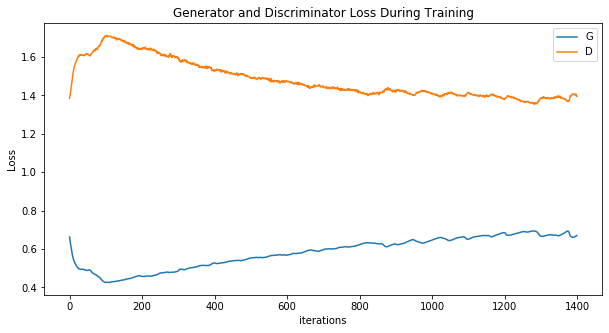

In [9]:
plot_train_loss()

# Animation

In [10]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

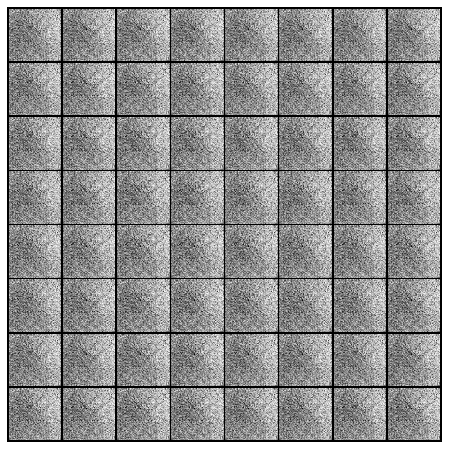

In [11]:
animate_gen_imgs()

# Anomaly Loss

In [12]:
latent_vector = torch.randn(1, latent_size, 1, 1, device = device, requires_grad=True)

def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    _, Test_Data_feature = D(Test_Data)
    _, G_Data_feature = D(G_Data)
    residual_loss = torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss = torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

z_optimizer = torch.optim.Adam([latent_vector],lr=0.01,betas=(0.5, 0.999))


test_data_root = "../../../OhSeHyeon/source/dataset/test/test_CFRP"
test_data_set = dataset.ImageFolder(root = test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))


# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# Train Latent Space Z

In [13]:
latent_space = []
auc=[]

def train_latent_space():
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data = G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step == 400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss > 500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [14]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  1
[0]	 Ano_loss : 2131.6638  Sum_of_z : 5.7097
[200]	 Ano_loss : 2121.0857  Sum_of_z : 1.4160
[400]	 Ano_loss : 2118.3799  Sum_of_z : -1.7490
picture  2
[0]	 Ano_loss : 871.8190  Sum_of_z : -1.8932
[200]	 Ano_loss : 846.3556  Sum_of_z : 0.4392
[400]	 Ano_loss : 845.1857  Sum_of_z : -1.1746
picture  3
[0]	 Ano_loss : 1287.6345  Sum_of_z : -1.1210
[200]	 Ano_loss : 1281.8229  Sum_of_z : 1.1232
[400]	 Ano_loss : 1281.0753  Sum_of_z : 1.3418
picture  4
[0]	 Ano_loss : 1588.6426  Sum_of_z : 1.3605
[200]	 Ano_loss : 1586.2177  Sum_of_z : 3.1989
[400]	 Ano_loss : 1585.5891  Sum_of_z : 3.1597
picture  5
[0]	 Ano_loss : 1351.4268  Sum_of_z : 3.0448
[200]	 Ano_loss : 1337.5488  Sum_of_z : -3.7464
[400]	 Ano_loss : 1336.1611  Sum_of_z : -0.5942
picture  6
[0]	 Ano_loss : 1994.0389  Sum_of_z : -0.5710
[200]	 Ano_loss : 1982.1294  Sum_of_z : 4.7094
[400]	 Ano_loss : 1980.5585  Sum_of_z : 3.4453
picture  7
[0]	 Ano_loss : 1339.8004  Sum_of_z : 3.4382
[200]	 Ano_loss : 1319.0475  Sum_of_z : 

[400]	 Ano_loss : 1693.7986  Sum_of_z : -12.6072
picture  55
[0]	 Ano_loss : 978.5019  Sum_of_z : -12.6836
[200]	 Ano_loss : 958.4089  Sum_of_z : -14.0821
[400]	 Ano_loss : 956.4315  Sum_of_z : -3.6382
picture  56
[0]	 Ano_loss : 2443.1338  Sum_of_z : -3.7826
[200]	 Ano_loss : 2428.0032  Sum_of_z : -2.8181
[400]	 Ano_loss : 2426.7498  Sum_of_z : -7.8075
picture  57
[0]	 Ano_loss : 2039.7888  Sum_of_z : -7.8420
[200]	 Ano_loss : 2019.9781  Sum_of_z : -8.4188
[400]	 Ano_loss : 2018.3314  Sum_of_z : -18.9869
picture  58
[0]	 Ano_loss : 2715.6543  Sum_of_z : -18.9232
[200]	 Ano_loss : 2698.6770  Sum_of_z : -1.6437
[400]	 Ano_loss : 2697.0520  Sum_of_z : 3.3143
picture  59
[0]	 Ano_loss : 2786.3477  Sum_of_z : 3.3188
[200]	 Ano_loss : 2785.3179  Sum_of_z : 7.1361
[400]	 Ano_loss : 2784.9146  Sum_of_z : 6.9429
picture  60
[0]	 Ano_loss : 1287.8171  Sum_of_z : 6.9342
[200]	 Ano_loss : 1286.3048  Sum_of_z : 12.8152
[400]	 Ano_loss : 1285.5287  Sum_of_z : 15.1565


---

# 이상 픽셀 수 확인 함수

In [15]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# Similar Z , Ano_Score and Segementation


In [16]:
diff_cnts = []
diff_points = []
anomaly_imgs = []


def compare_imgs(real_img, generated_img, i, reverse=False, threshold=50):
    global anomaly_img
    
    score = Anomaly_loss(real_img, generated_img)
    score = round(score.item(), 2)
    
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    negative = np.zeros_like(real_img)
    
    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img
    diff_img[diff_img <= threshold] = 0
    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)
    # anomaly_img 추출
    anomaly_imgs.append(anomaly_img)
    
    fig, plots = plt.subplots(1, 4)
    if auc[i] == 0:
        fig.suptitle(f'Normal - (anomaly score: {score:.4})')
    else :
        fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')

/home/piai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


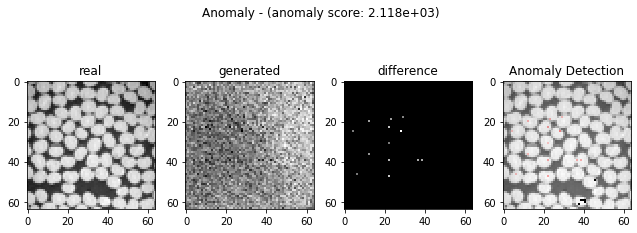

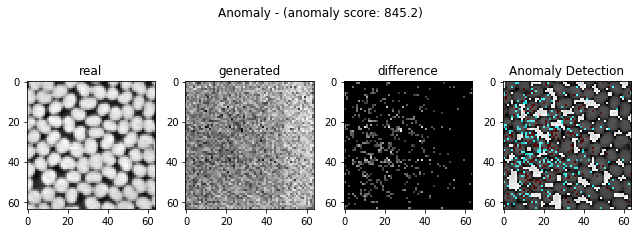

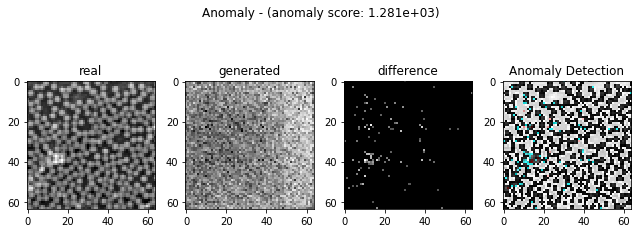

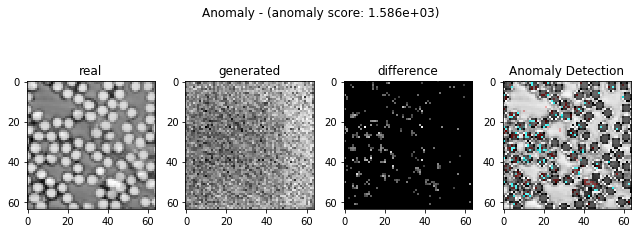

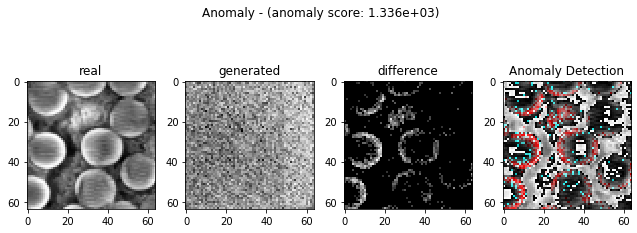

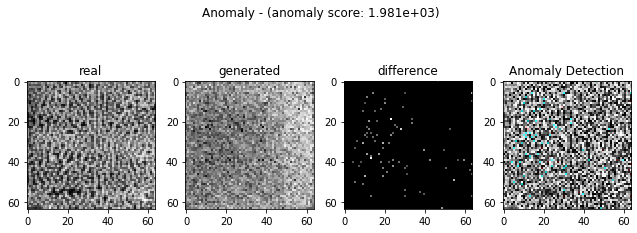

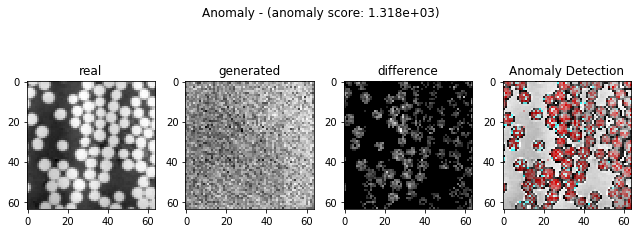

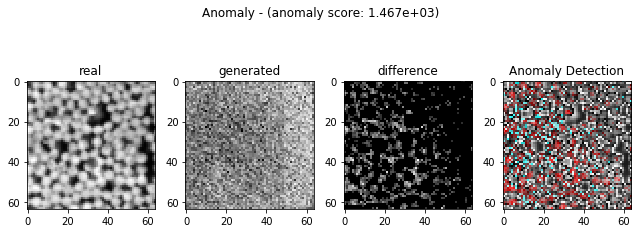

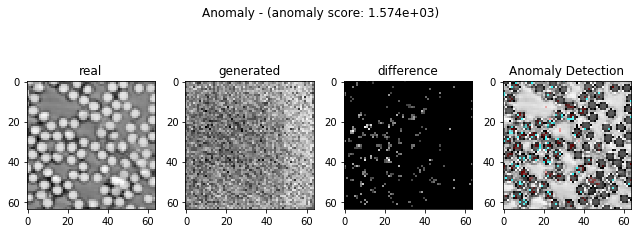

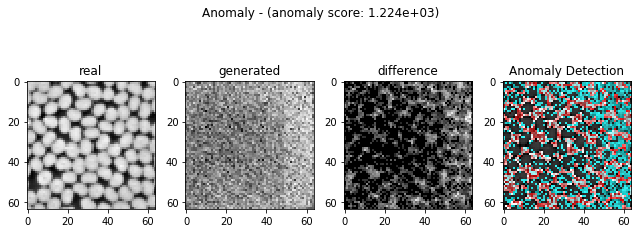

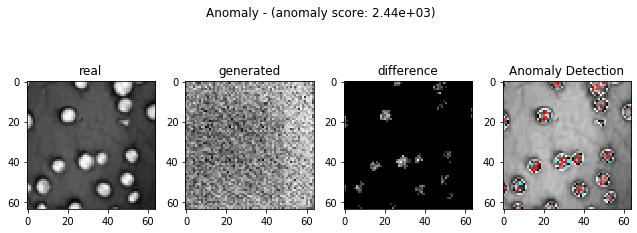

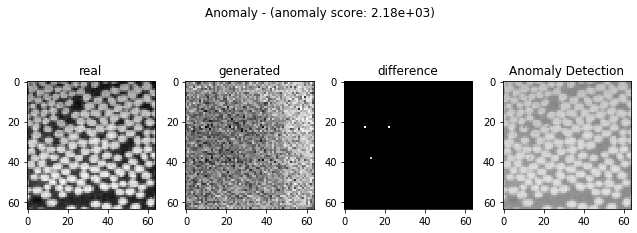

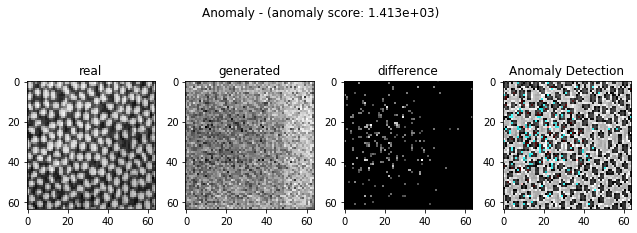

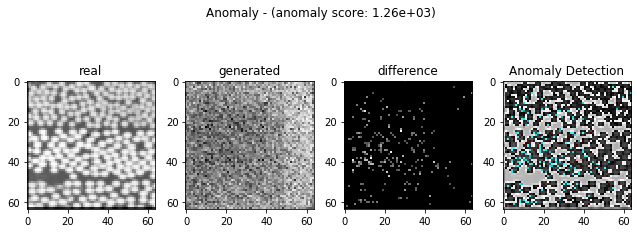

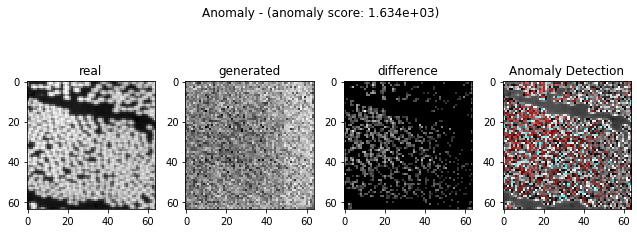

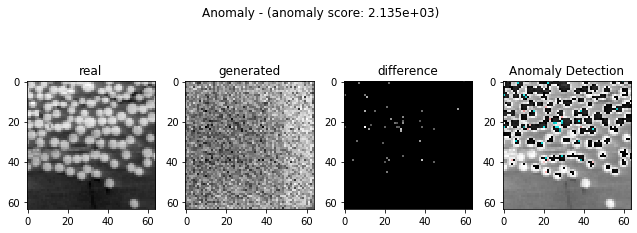

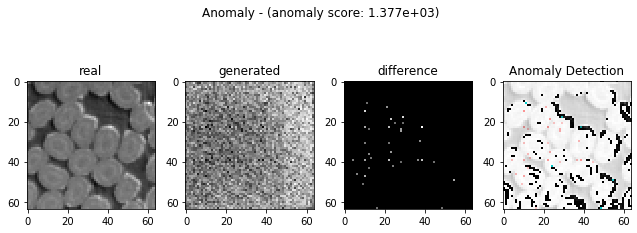

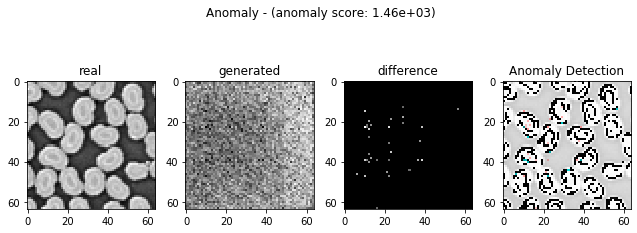

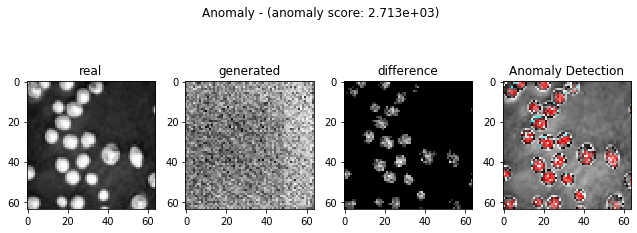

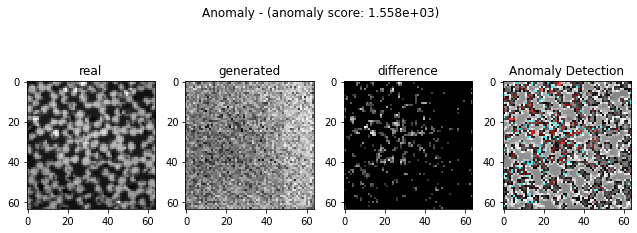

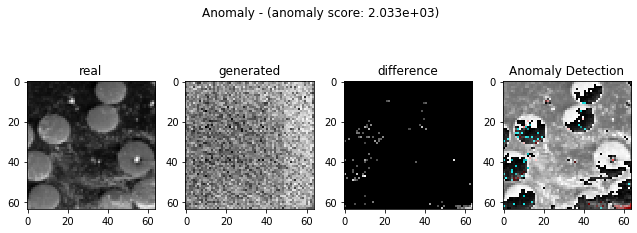

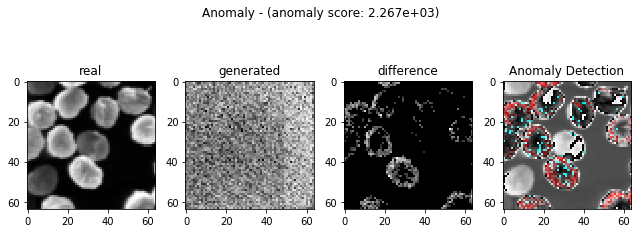

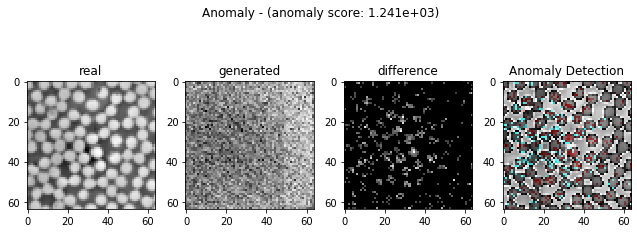

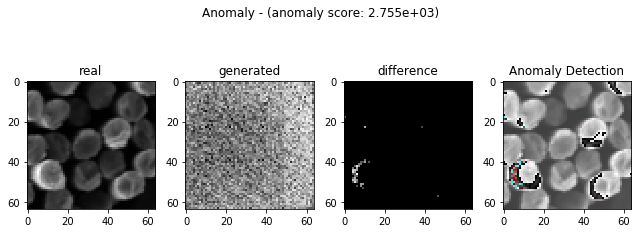

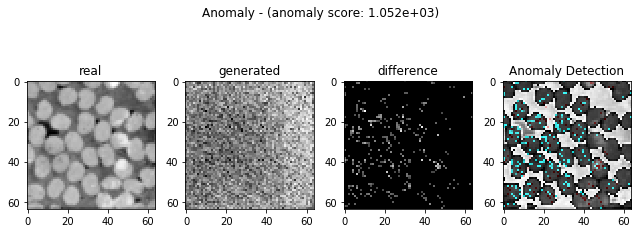

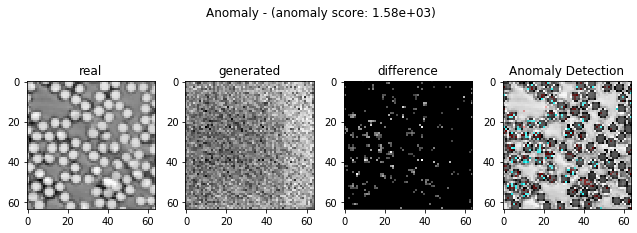

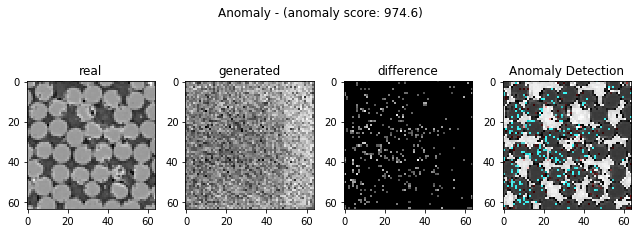

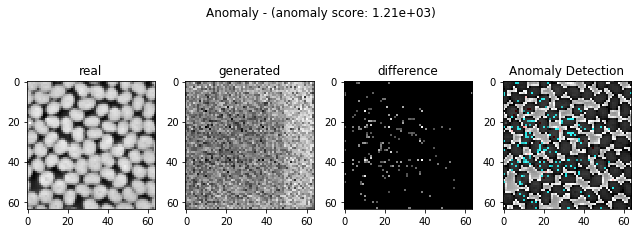

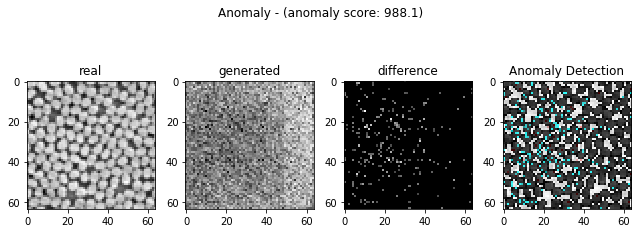

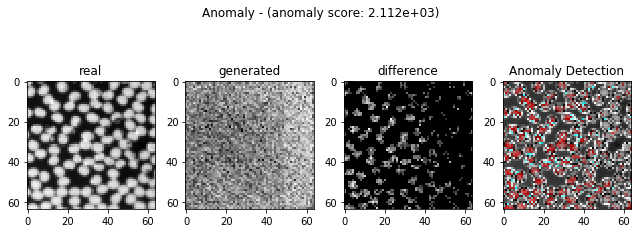

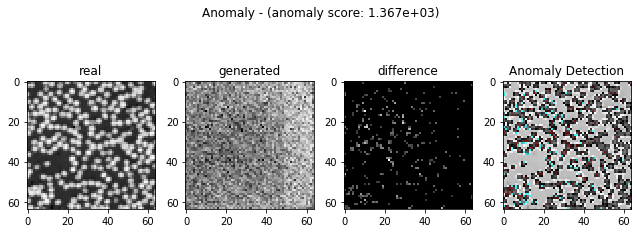

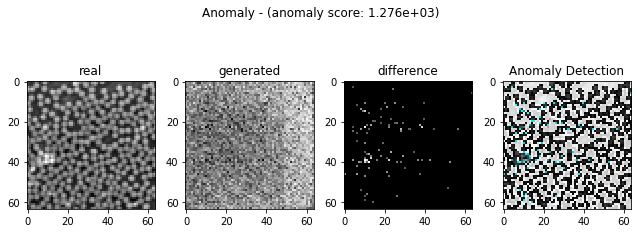

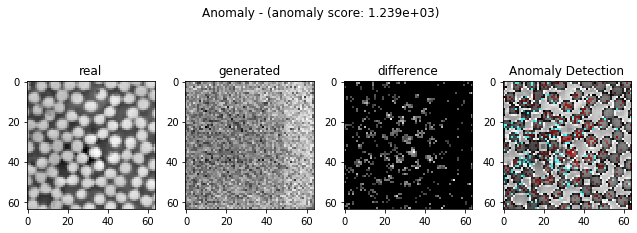

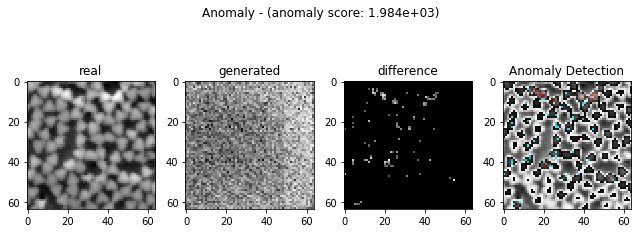

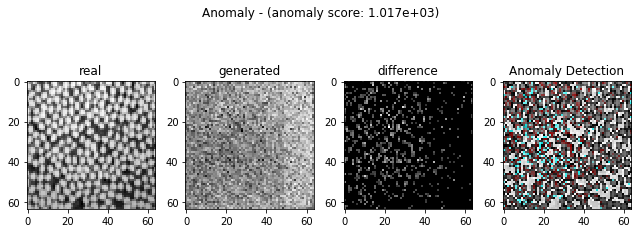

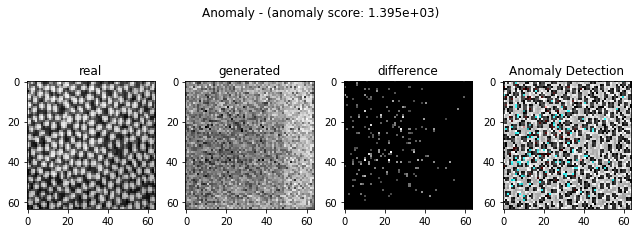

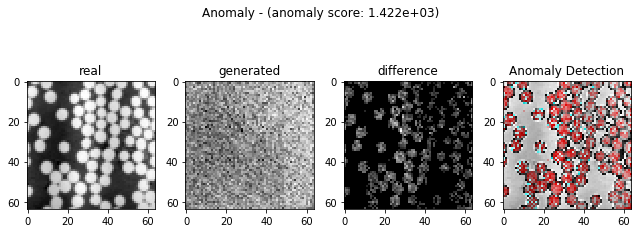

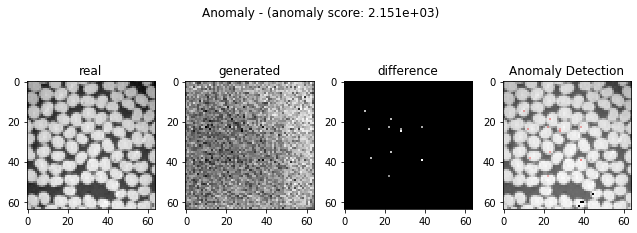

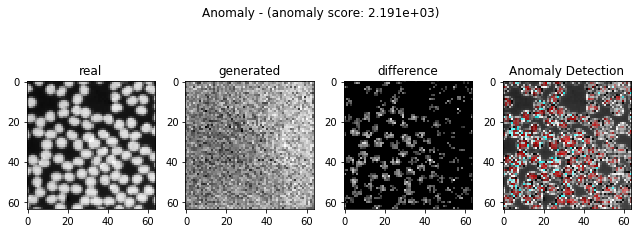

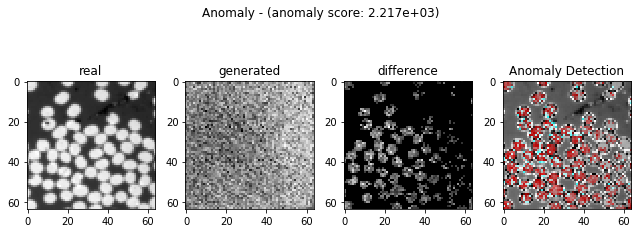

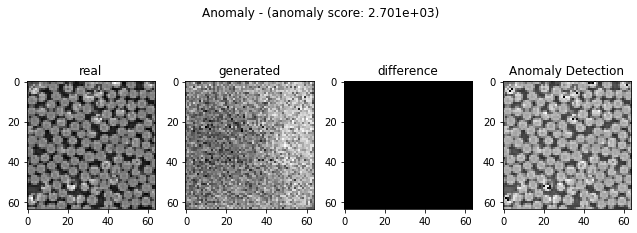

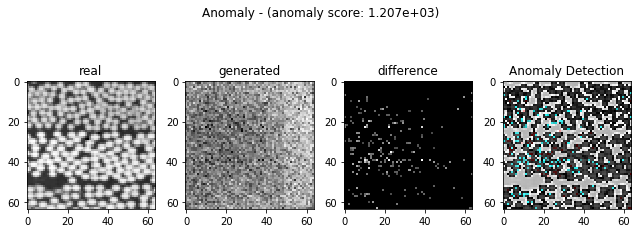

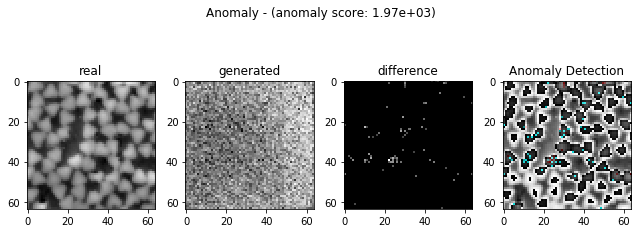

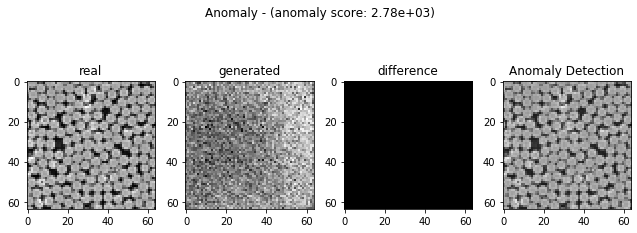

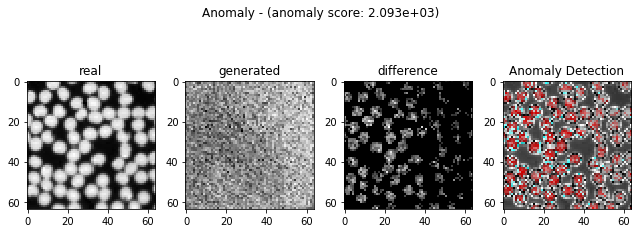

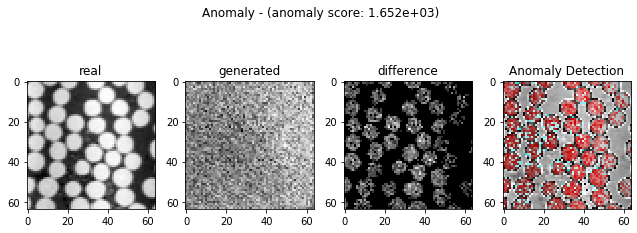

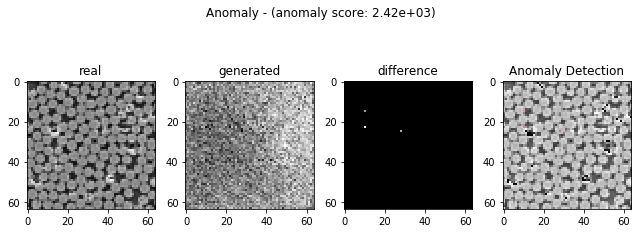

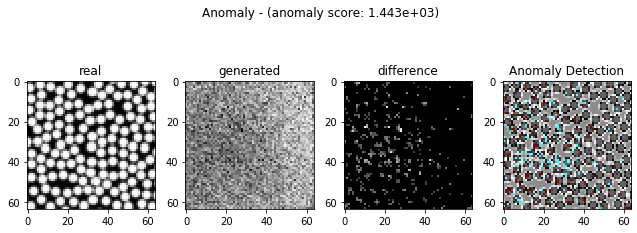

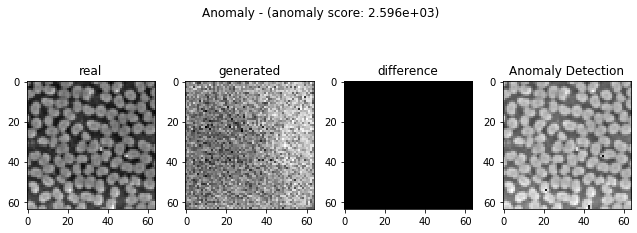

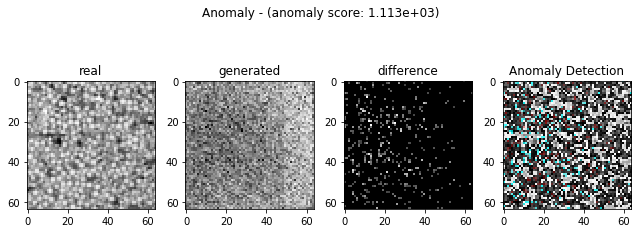

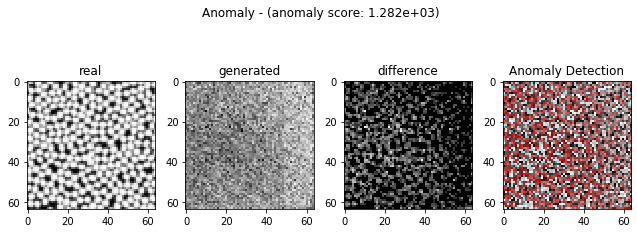

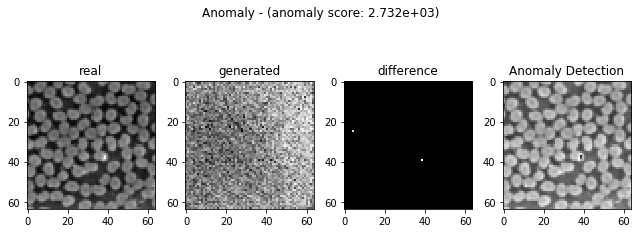

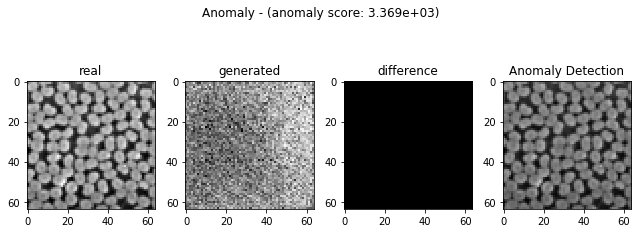

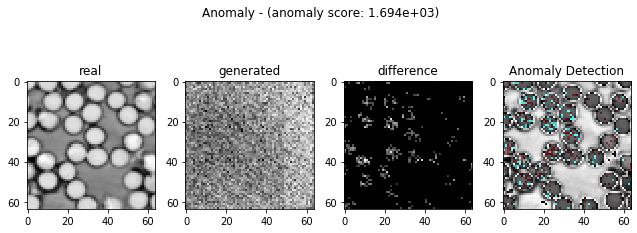

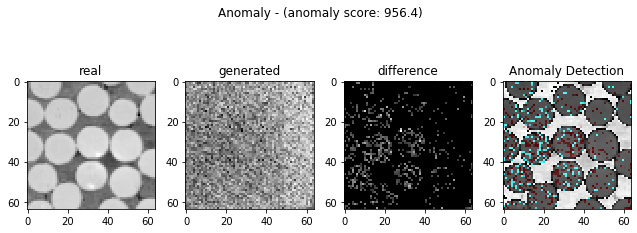

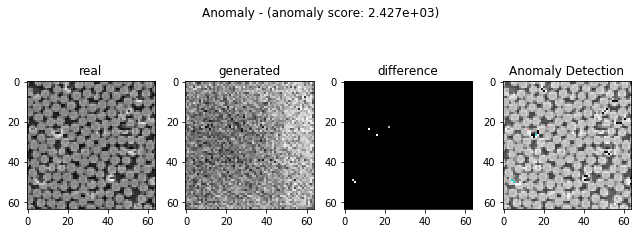

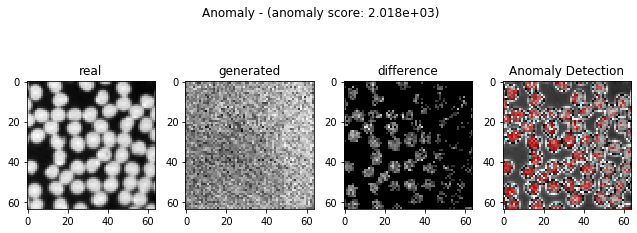

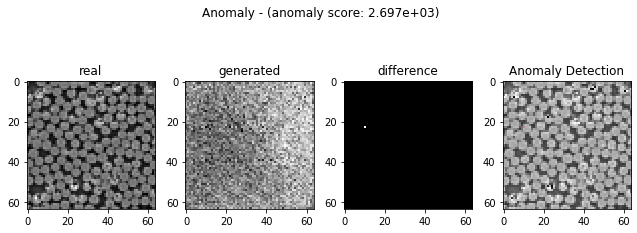

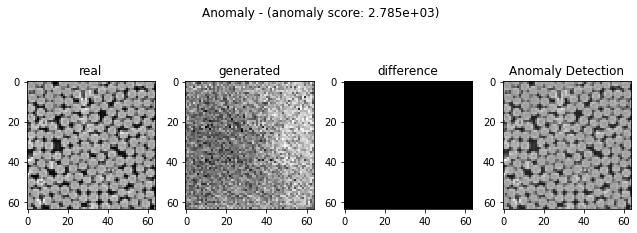

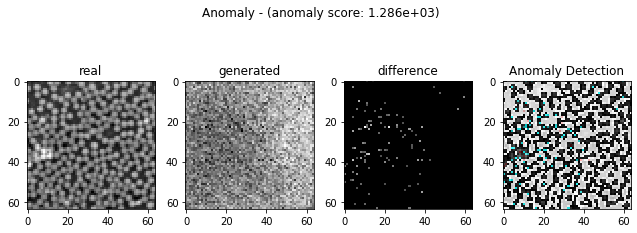

In [17]:
for i,data in enumerate(test_data_loader,0):
    test_img = data[0].to(device)

    #for i in range(len(latent_space)):
    update_z = latent_space[i]
    R_img = test_img
    G_img = G(update_z).to(device)
    
    if i in [9]:
        compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
    else:
        compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

---

# 분율 추출

In [18]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[3.17382812e-03 1.17187500e-01 2.46582031e-02 6.59179688e-02
 1.75781250e-01 1.87988281e-02 3.32519531e-01 2.88085938e-01
 6.25000000e-02 5.93994141e-01 5.00488281e-02 7.32421875e-04
 5.32226562e-02 5.34667969e-02 2.78076172e-01 9.76562500e-03
 8.30078125e-03 8.05664062e-03 1.34765625e-01 1.24755859e-01
 2.19726562e-02 1.46728516e-01 1.39892578e-01 9.52148438e-03
 7.69042969e-02 6.95800781e-02 8.42285156e-02 4.05273438e-02
 5.78613281e-02 2.22656250e-01 7.25097656e-02 2.17285156e-02
 1.46728516e-01 2.51464844e-02 1.89941406e-01 4.63867188e-02
 3.45214844e-01 2.68554688e-03 2.39257812e-01 2.71484375e-01
 0.00000000e+00 5.17578125e-02 1.80664062e-02 0.00000000e+00
 2.86865234e-01 4.12597656e-01 7.32421875e-04 1.03515625e-01
 0.00000000e+00 9.93652344e-02 5.09277344e-01 4.88281250e-04
 0.00000000e+00 8.20312500e-02 1.49658203e-01 1.22070312e-03
 2.77099609e-01 2.44140625e-04 0.00000000e+00 2.53906250e-02]


---

# 분산 추출

In [21]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)
        print(corr_coeffi)

In [22]:
cal_corr_coeffis()

print(corr_coeffis)

0.02489758962274269
-0.026802687578517555
-0.13429871289512468
0.0630422386843741
-0.0337218964294243
0.14792656660410614
0.06817705971140976
0.0975115169691729
-0.015841543441816007
-0.025415390914188804
-0.13909330084208613
-0.2773500981126146
-0.029063953212063905
-0.01677712236970385
0.11557595642828139
0.03161636433425286
0.12707717422864082
-0.21097417532017548
0.2218664614002921
0.03907134669900148
0.477364631269779
0.282680396737919
0.03207547395556354
-0.06108875157341201
0.027547277446584528
-0.05546122641415083
0.0027469895754157064
0.1094133395461124
-0.013807729192506224
0.02102022125745895
-0.04810216656715843
-0.11096923422925806
-0.023190611300526756
-0.25372842741421975
-0.042628230709339826
0.03648515838088437
0.05260706809491003
0.16408288585570985
0.017794398034949428
0.13401056212722576
-inf
0.09416713747762598
-0.34032023755067387
-inf
0.017812666310409803
0.06754130087420027
0.6546536707079772
0.03764510858853762
-inf
0.05255551260954741
0.05182669878277117
1.0
-

ValueError: x and y must have length at least 2.

---

# 모델 저장 및 읽기

In [21]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "G" : G.state_dict(),
        #"latent_space" : latent_space.state_dict(), # nn.model만 가지는 기능
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [22]:
save_pretrained()

In [23]:
pretrained_D = Discriminator().to(device)
pretrained_G = Generator().to(device)
#pretrained_latent_space = [] # 다시 학습해야 함

def load_pretrained():
    global pretrained_D
    global pretrained_G
    #global pretrained_latent_space
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_G.load_state_dict(pretrained["G"])
    #pretrained_latent_space.load_state_dict(pretrained["latent_space"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_G)
    #print("pretrained_latent_space :", pretrained_latent_space)

In [24]:
load_pretrained()

In [25]:
def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    
    _, Test_Data_feature = pretrained_D(Test_Data)
    _, G_Data_feature = pretrained_D(G_Data)
    residual_loss = torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss = torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

In [26]:
# train latent_space

latent_space = []
auc = []

def train_latent_space():
    global latent_space
    global auc
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data   = pretrained_G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step==400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss>500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [27]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  1
[0]	 Ano_loss : 1266.3403  Sum_of_z : -3.3242
[200]	 Ano_loss : 1264.7040  Sum_of_z : 0.9610
[400]	 Ano_loss : 1264.6361  Sum_of_z : 1.0947
picture  2
[0]	 Ano_loss : 1201.3168  Sum_of_z : 1.3532
[200]	 Ano_loss : 1199.7808  Sum_of_z : 11.9149
[400]	 Ano_loss : 1199.6984  Sum_of_z : 12.8498
picture  3
[0]	 Ano_loss : 1015.5364  Sum_of_z : 12.9203
[200]	 Ano_loss : 1013.7377  Sum_of_z : 6.7273
[400]	 Ano_loss : 1013.6226  Sum_of_z : -1.5176
picture  4
[0]	 Ano_loss : 524.4009  Sum_of_z : -1.5813
[200]	 Ano_loss : 523.0158  Sum_of_z : -6.6464
[400]	 Ano_loss : 522.9283  Sum_of_z : -4.0442
picture  5
[0]	 Ano_loss : 1090.5264  Sum_of_z : -4.1989
[200]	 Ano_loss : 1090.0314  Sum_of_z : -11.3059
[400]	 Ano_loss : 1090.0150  Sum_of_z : -12.8962
picture  6
[0]	 Ano_loss : 345.9109  Sum_of_z : -12.8769
[200]	 Ano_loss : 344.4709  Sum_of_z : 4.4213
[400]	 Ano_loss : 344.2828  Sum_of_z : 12.5208
picture  7
[0]	 Ano_loss : 671.7592  Sum_of_z : 12.4988
[200]	 Ano_loss : 670.0259  Sum_of

In [28]:
def test():
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)

        #for i in range(len(latent_space)):
        update_z = latent_space[i]
        R_img = test_img
        G_img = pretrained_G(update_z).to(device)

        if i in [9]:
            compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
        else:
            compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

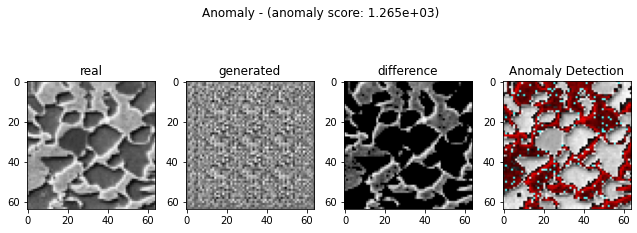

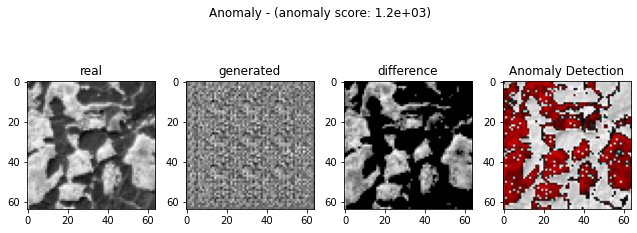

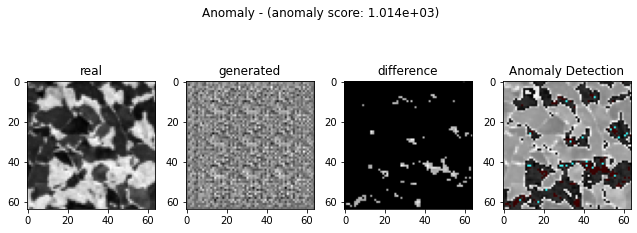

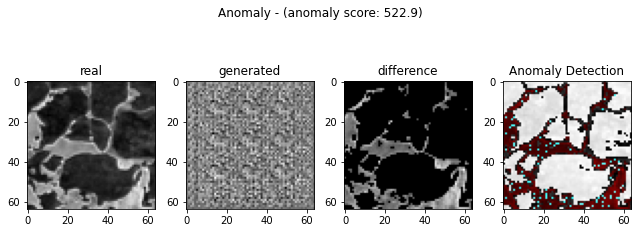

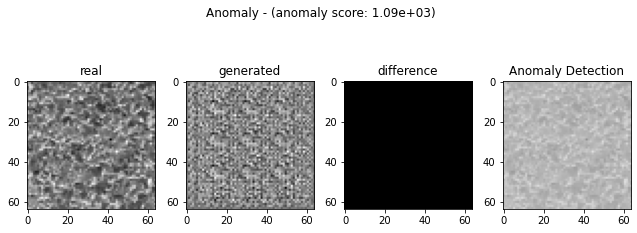

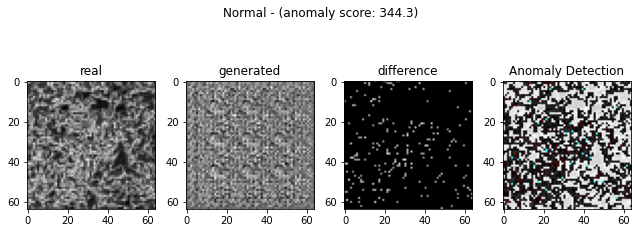

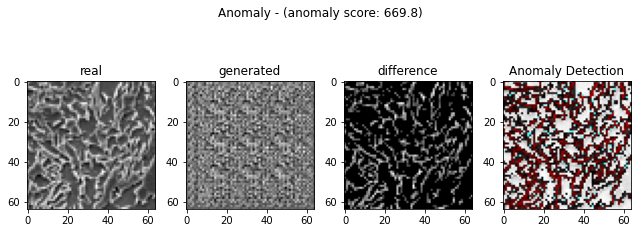

In [29]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [30]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.42578125 0.46264648 0.04516602 0.2355957  0.         0.04980469
 0.29760742]


In [31]:
cal_corr_coeffis()

print(corr_coeffis)

[0.03930323451955458, 0.09824271107967668, -0.28914111459826475, 0.19809595979534306, -inf, 0.04507935167666852, -0.08497257982755216]


---

# anomaly detection 이미지 추출

In [32]:
anomaly_imgs

[array([[[242, 242, 242],
         [246, 246, 246],
         [121,   0,   0],
         ...,
         [210, 210, 210],
         [176, 176, 176],
         [222, 222, 222]],
 
        [[248, 248, 248],
         [242, 242, 242],
         [ 87,   1,   1],
         ...,
         [238, 238, 238],
         [238, 238, 238],
         [190, 190, 190]],
 
        [[236, 236, 236],
         [230, 230, 230],
         [ 77,   3,   3],
         ...,
         [230, 230, 230],
         [232, 232, 232],
         [238, 238, 238]],
 
        ...,
 
        [[230, 230, 230],
         [248, 248, 248],
         [212, 212, 212],
         ...,
         [142, 142, 142],
         [ 85,  85,  85],
         [130, 130, 130]],
 
        [[228, 228, 228],
         [244, 244, 244],
         [230, 230, 230],
         ...,
         [105, 105, 105],
         [150, 150, 150],
         [252, 252, 252]],
 
        [[218, 218, 218],
         [228, 228, 228],
         [246, 246, 246],
         ...,
         [182, 182, 182],
  

# 이미지 저장 함수

In [33]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs"):
        os.mkdir("anomaly_imgs")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [34]:
save_imgs("./anomaly_imgs", anomaly_imgs)

image saving complete


---

# 티타늄(Ti64) 상대 밀도 계산

In [35]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)

[1.88621094 2.04952393 0.20008545 1.04368896 0.         0.22063477
 1.31840088]
